In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import warnings
import torch
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.models import Prophet, ExponentialSmoothing, AutoARIMA, Theta, RegressionModel
from darts.metrics import rmse
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
import darts.metrics as dme
from functools import reduce
from data_sources import *
import logging

In [23]:
# general settings
class CFG:
    img_dim1 = 20
    img_dim2 = 10
    #  for faster iteration / execution
    cutoff = '2018-01-01'
# adjust the parameters for displayed figures
plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})
# warnings.simplefilter(action='ignore', category= FutureWarning)
warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [25]:
# helper functions
def my_rmse(x,y):
    return np.round(np.sqrt(mse(x, y)), 4)

# Darts
An interesting example of a library combining multiple time series models is `darts` https://unit8co.github.io/darts/ . It takes a slightly different approach then AutoTS: instead of automatically combining a set of models from a predefined list, it allows us to setup evaluation of different models in standardized manner.

![1_8nIk2qAyub5qtr_v7TrD9Q (1).png](attachment:40af9230-4fa5-412b-9c57-0624b7331dad.png)

The list of possible candidate models is quite exhaustive:

* ARIMA
* Auto-ARIMA
* Baseline Models
* Block Recurrent Neural Networks
* Exponential Smoothing
* Fast Fourier Transform
* LightGBM Model
* Linear Regression model
* N-BEATS
* Facebook Prophet
* Random Forest
* Regression ensemble model
* Regression Model
* Recurrent Neural Networks
* Temporal Convolutional Network
* Temporal Fusion Transformer (TFT)
* Theta Method
* Transformer Model
* VARIMA

This package and `Kats` discussed in the next section have certain overlap in their focus, so in order to avoid redundancy we will take something of an *a la carte* approach.

## Backtesting
In this section we will focus on a very useful feature of `darts`: backtesting. A frequent approach to validation of time series models is to split the data on time: training set are all the observations up to some timepoint $t_0$ and validation is the part afterwards. While simple to set up, this approach runs the risk of overfitting to our chosen validation set. The `historical_forecast` method built into all the models in `darts` solves this problem by allowing us to perform a walk-forward validation:

![1_yE6-RsMd0D2XIGgld_o_KA.jpeg](attachment:102e64bc-fda5-481e-8dc4-b71e27ea35fa.jpeg)

For the visually challenged people like me:
* we use an expanding training window
* for each run, we train the model on the training set and generate a forecast on test
* next run has an extended training set and a shifted test



In [26]:
def eval_model(
        model,
        flow,
        past_covariates=None,
        future_covariates=None,
        retrain=False,
        forecast_horizon=10,
        last_obs=200):

    # Past and future covariates are optional because they won't always be used in our tests
    # We backtest the model on the last 20% of the flow series, with a horizon of `forecast_horizon` steps:
    backtest = model.historical_forecasts(
        series=flow,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        start=0.8,
        retrain=retrain,
        verbose=True,
        forecast_horizon=forecast_horizon)

    flow[-len(backtest) - last_obs:].plot()
    backtest.plot(label='backtest (n=' + str(forecast_horizon) + ')')
    print('Backtest RMSE = {}'.format(np.round( rmse(flow, backtest) )))

Format the data into `darts` format:

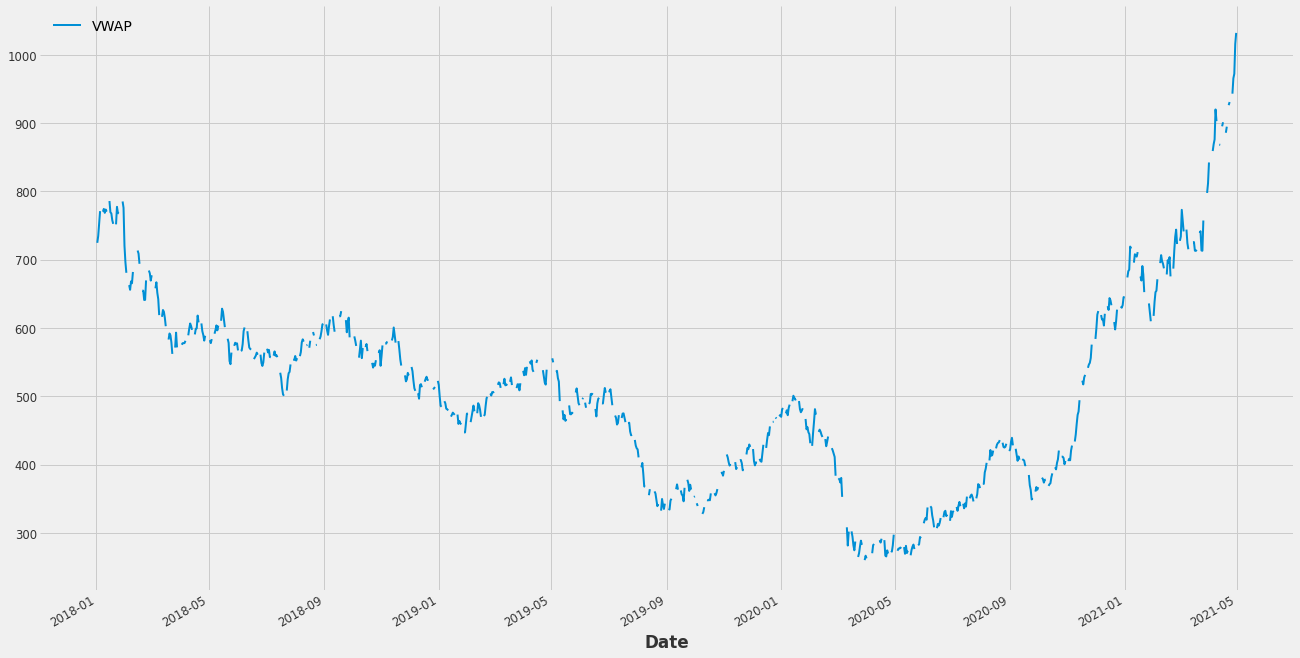

In [27]:
df = pd.read_csv(stocks, usecols=['Date', 'VWAP'])
df = df.loc[df.Date > CFG.cutoff]
series = TimeSeries.from_dataframe(
    df,
    'Date',
    'VWAP',
    freq='D'
)

series.plot()
# df.set_index('Date').VWAP.plot()

We begin with exponential smoothing

In [28]:
# Exponential Smoothing can't handle NANs
series = fill_missing_values(series)

# split into training / validation
train, val = series[:-60], series[-60:]

  0%|          | 0/226 [00:00<?, ?it/s]

Backtest RMSE = 31.0


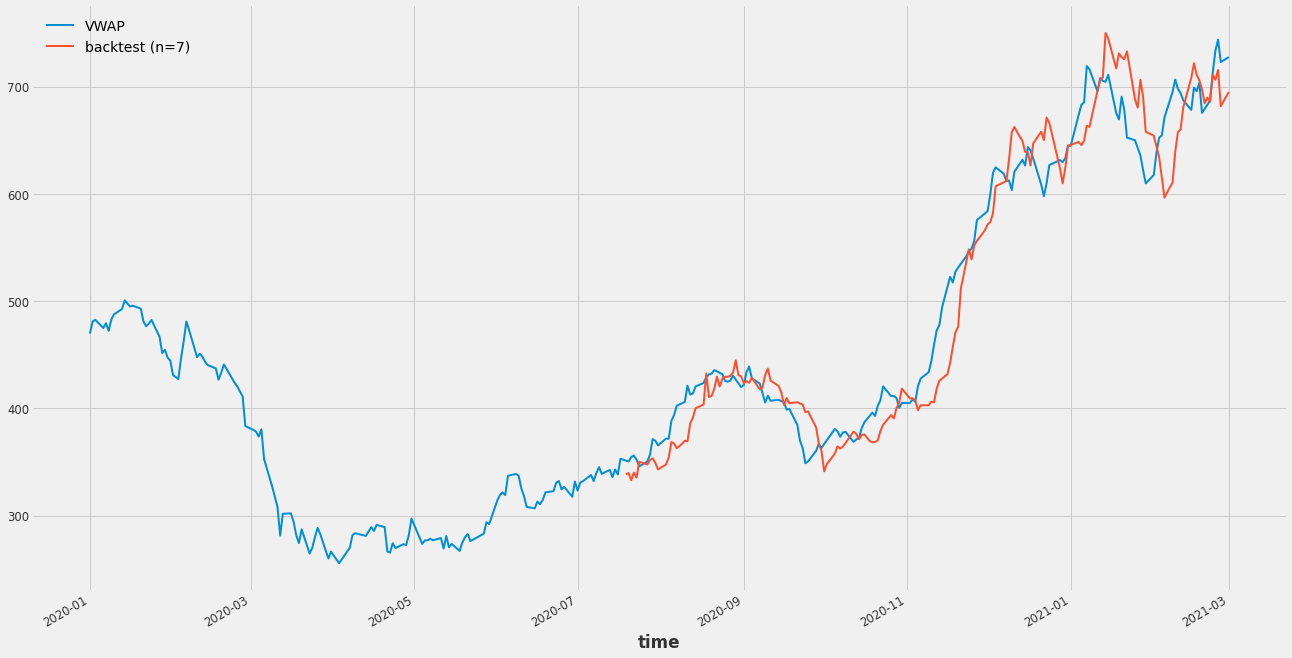

In [29]:
model = ExponentialSmoothing()
# try forecast_horizon = 30
eval_model(
    model,
    flow=train,
    retrain=True,
    forecast_horizon=7
)

  0%|          | 0/218 [00:00<?, ?it/s]

Backtest RMSE = 56.0


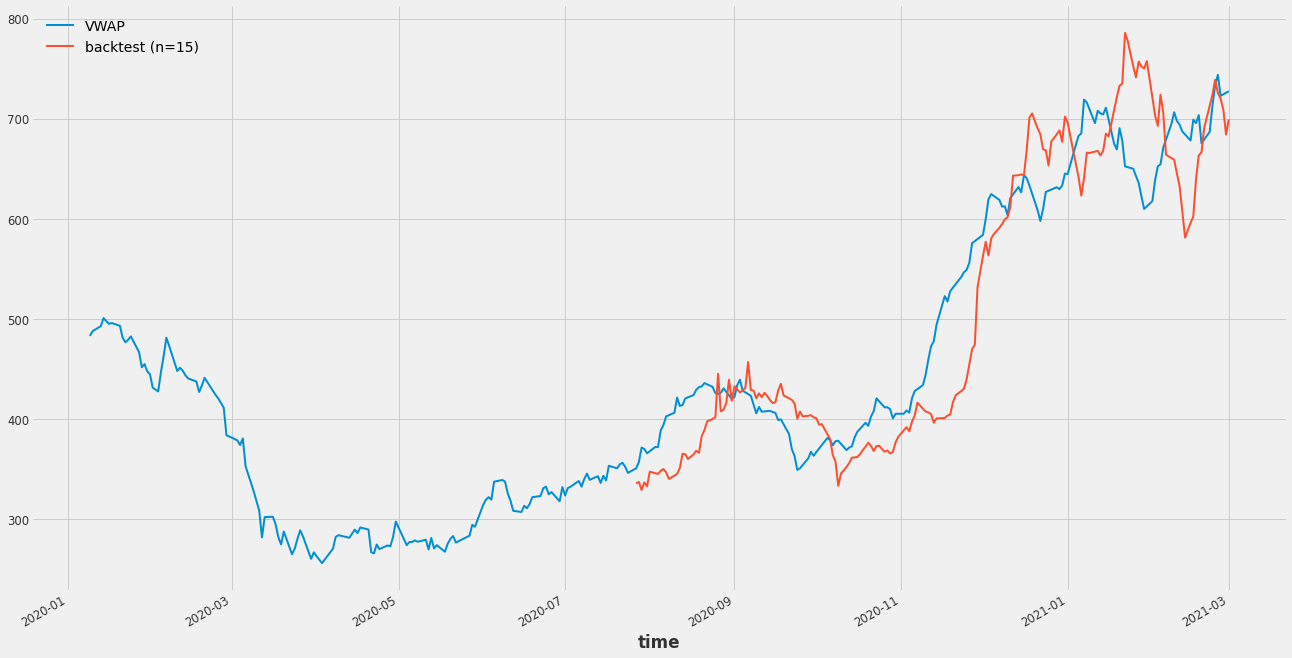

In [30]:
# try forecast_horizon = 30
eval_model(
    model,
    flow=train,
    retrain=True,
    forecast_horizon=15
)

  0%|          | 0/203 [00:00<?, ?it/s]

Backtest RMSE = 92.0


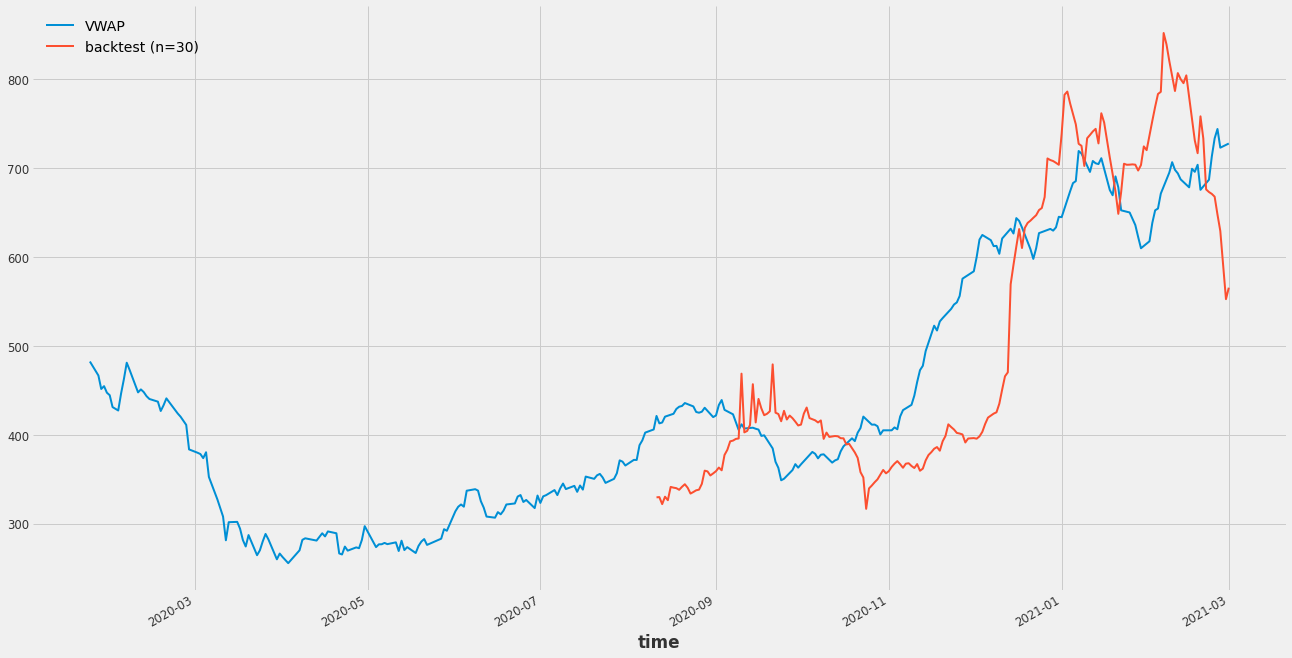

In [31]:
# try forecast_horizon = 30
eval_model(
    model,
    flow=train,
    retrain=True,
    forecast_horizon=30
)

Next: Prophet, which `darts` also wraps. Not surprisingly, the backstesting - even at default parameters - takes a little longer than before.

  0%|          | 0/226 [00:00<?, ?it/s]

Backtest RMSE = 54.0


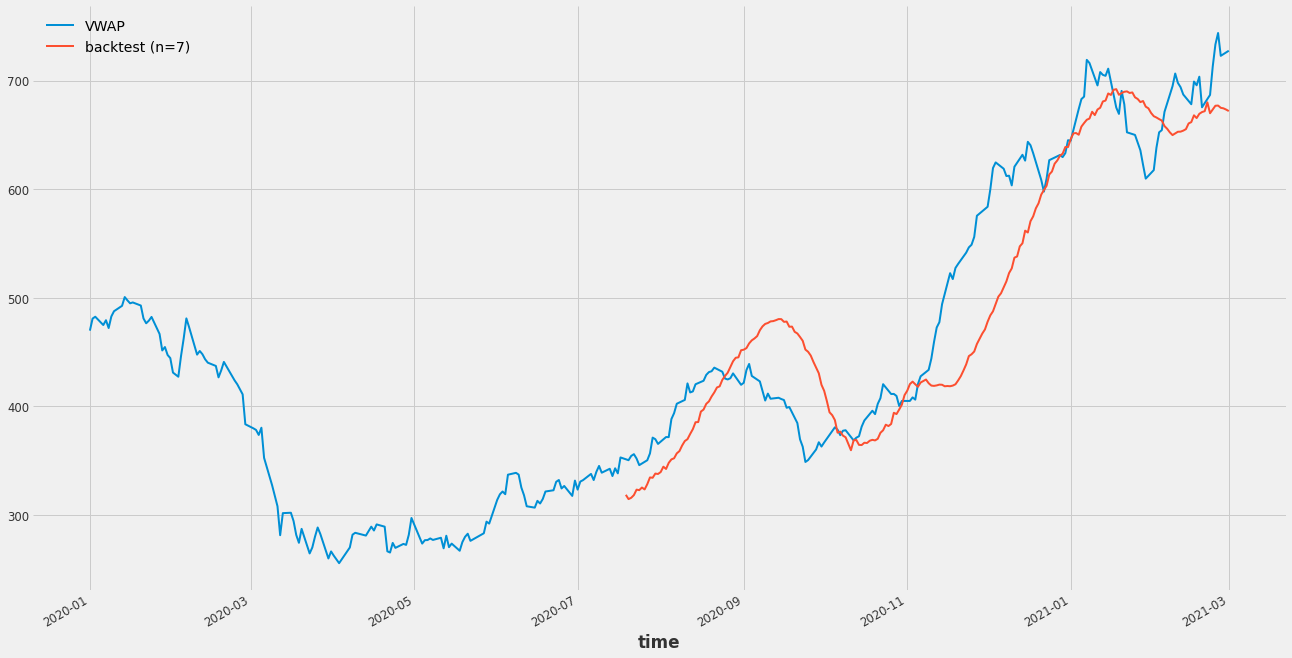

In [32]:
df = pd.read_csv(stocks, usecols=['Date', 'VWAP'])
df = df.loc[df.Date > CFG.cutoff]

series = TimeSeries.from_dataframe(
    df,
    'Date',
    'VWAP',
    freq='D'
)

model = Prophet(daily_seasonality=True)

eval_model(
    model,
    flow=train,
    retrain=True,
    forecast_horizon=7,
)

No overview of vintage methods would be complete without ARIMA

  0%|          | 0/226 [00:00<?, ?it/s]

Backtest RMSE = 31.0


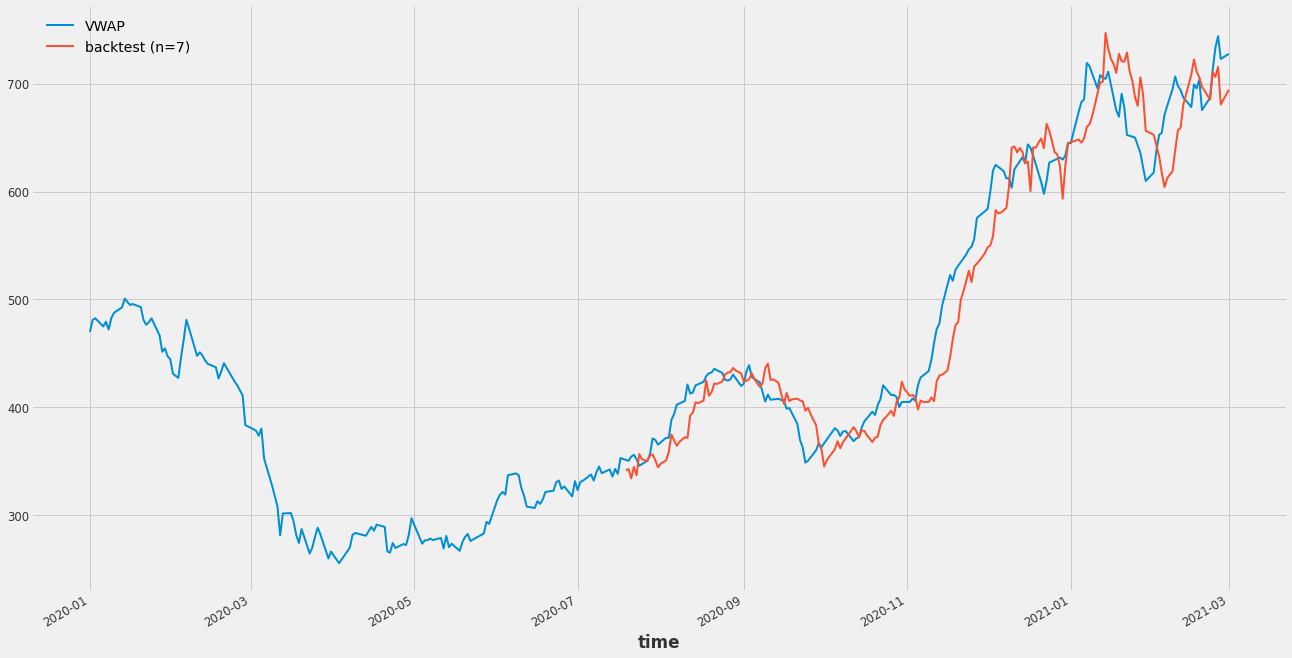

In [33]:
df = pd.read_csv(stocks, usecols=['Date', 'VWAP'])

df = df.loc[df.Date > CFG.cutoff]

series = TimeSeries.from_dataframe(
    df,
    'Date',
    'VWAP',
    freq='D'
)

series = fill_missing_values(series)

model = AutoARIMA()

eval_model(
    model,
    flow=train,
    retrain=True,
    forecast_horizon=7
)

An interesting feature of `darts` is that unlike some other packages, we can use deep learning models in exact same manner. The package can incorporate different DL architectures (RNN, LSTM, Transformers) as well as hybrid approaches (N-Beats).

Since this is our first venture into the #DeepLearnEverything space, let's start with the basics and fit an RNN:
- the first DL architecture focus on sequential data
- memory (vs LSTM)
- will get a full episode of their own

In [34]:
df = pd.read_csv(stocks, usecols=['Date', 'VWAP'])

df = df.loc[df.Date > CFG.cutoff]

series = TimeSeries.from_dataframe(
    df,
    'Date',
    'VWAP',
    freq='D'
)

series = fill_missing_values(series)

# split into training / validation
train, val = series[:-60], series[-60:]

transformer = Scaler()

train_transformed = transformer.fit_transform(train)

val_transformed = transformer.transform(val)

series_transformed = transformer.transform(series)

# scale
model = RNNModel(
    model="RNN",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=10,
    optimizer_kwargs={"lr": 1e-3},
    model_name="muh_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)

# trainer = Trainer(accelerator='gpu')

In [35]:
# eval_model(model, flow = train_transformed, retrain = True, forecast_horizon = 7) sadly, workaround needed due to my failure to suppress pages and pages of warnings
backtest = model.historical_forecasts(
    series=train_transformed,
    past_covariates=None,
    future_covariates=None,
    start=0.8,
    retrain=True,
    verbose=True,
    forecast_horizon=7
)

  0%|          | 0/226 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 57it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 58it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 59it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 60it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 61it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 62it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 63it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 64it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 65it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 66it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 67it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 68it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 69it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 70it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 71it [00:00, ?it/s]

Backtest RMSE = 0.0


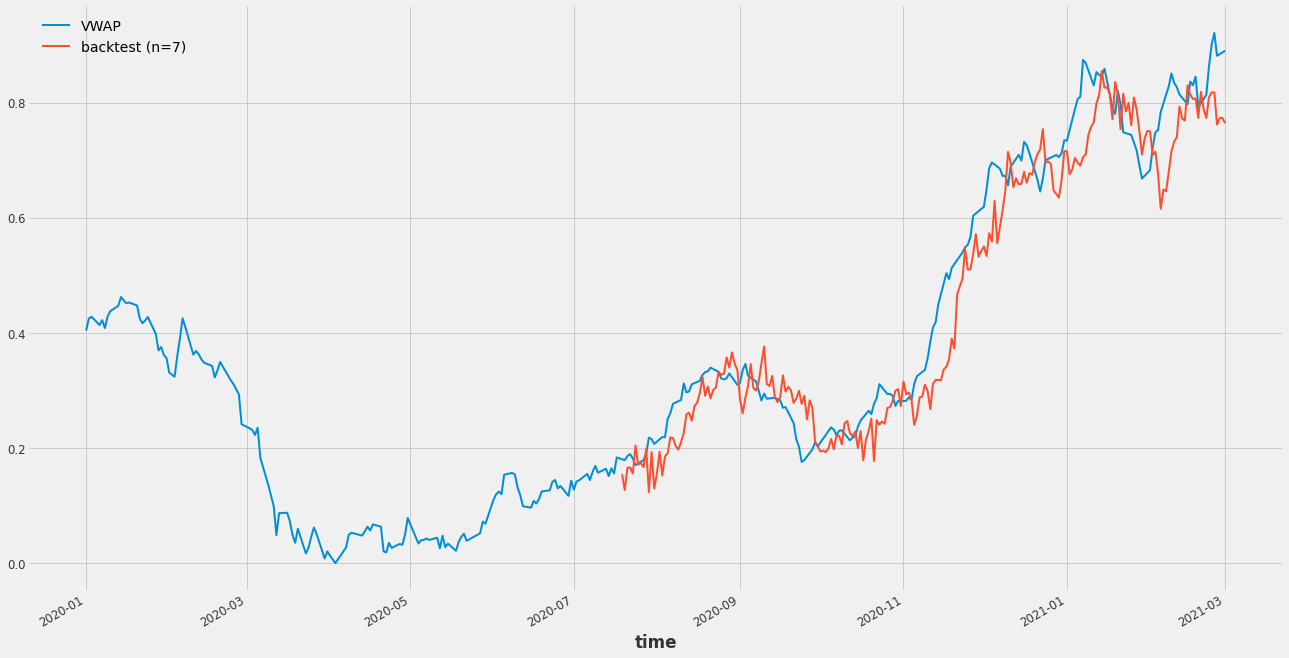

In [36]:
train_transformed[-len(backtest) - 200:].plot()
backtest.plot(label='backtest (n=7)')
print('Backtest RMSE = {}'.format(np.round(rmse(train_transformed, backtest))))

Now that we have seen how to evaluate individual models, the next step is fairly natural:

## Ensembling

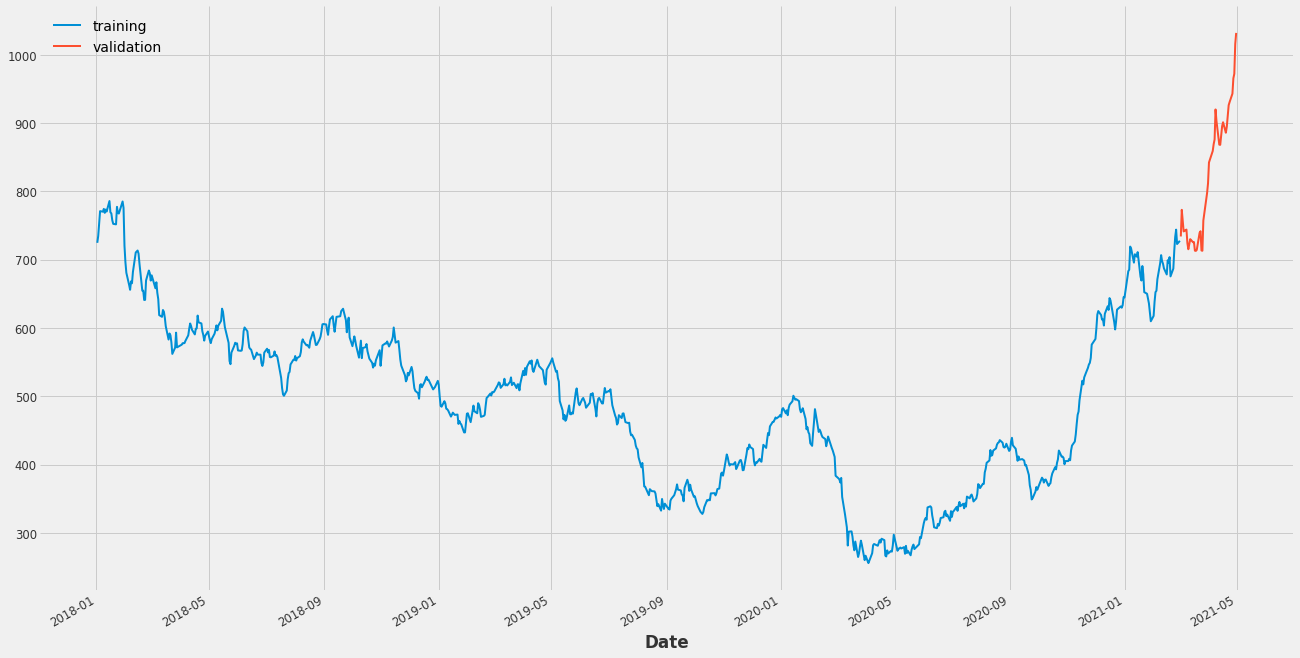

In [37]:
# prepare the data
df = pd.read_csv(stocks, usecols = ['Date', 'VWAP'])

df = df.loc[df.Date > CFG.cutoff]

series = TimeSeries.from_dataframe(
    df,
    'Date',
    'VWAP',
    freq='D'
)

series = fill_missing_values(series)

# split into training / validation
train, val = series[:-60], series[-60:]

train.plot(label='training')

val.plot(label='validation')

plt.legend()

In [38]:
# define the list of models we use
models = [# NaiveSeasonal(6),
          AutoARIMA(),
          # NaiveDrift(),
          Theta(),
          # ExponentialSmoothing(),
          Prophet()
         ]

# create the back tests for the individual models
model_predictions = [m.historical_forecasts(
    series,
    # start of the backtesting period for the individual models
    start=pd.Timestamp('2020-01-01'),
    forecast_horizon=12,
    stride=12,
    last_points_only=False,
    verbose=True
)
    for m in models]

model_predictions = [reduce((lambda a, b: a.append(b)), model_pred) for model_pred in model_predictions]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [39]:
model_predictions_stacked = model_predictions[0]
for model_prediction in model_predictions[1:]:
    model_predictions_stacked = model_predictions_stacked.stack(model_prediction)

With historical forecasts calculated through backtesting, we can move towards training an ensemble model combining our component series.

In [40]:
# setup our ensembling model
regr_model = RegressionModel(
    lags=None,
    lags_future_covariates=[0],
    # anything with .fit and .predict methods from sklearn will do here - LinearRegression by default
    model= Ridge()
)

# adjust index on the target series
series_target = series.slice_intersect(model_predictions[0])

In [41]:
# backtest for the RegressionModel
ensemble_pred = regr_model.historical_forecasts(
    series=series_target,
    future_covariates=model_predictions_stacked,
    # start of the calibration periods for the ensemble
    start=pd.Timestamp('2020-06-01'),
    forecast_horizon=3,
    verbose=True
)

  0%|          | 0/326 [00:00<?, ?it/s]

Finally, let's see how good the regression performs, compared to the original forecasts:


Regression coefficients for the individual models:
Learned coefficient for Auto-ARIMA: 0.95
Learned coefficient for Theta(2): 0.16
Learned coefficient for Prophet: -0.10


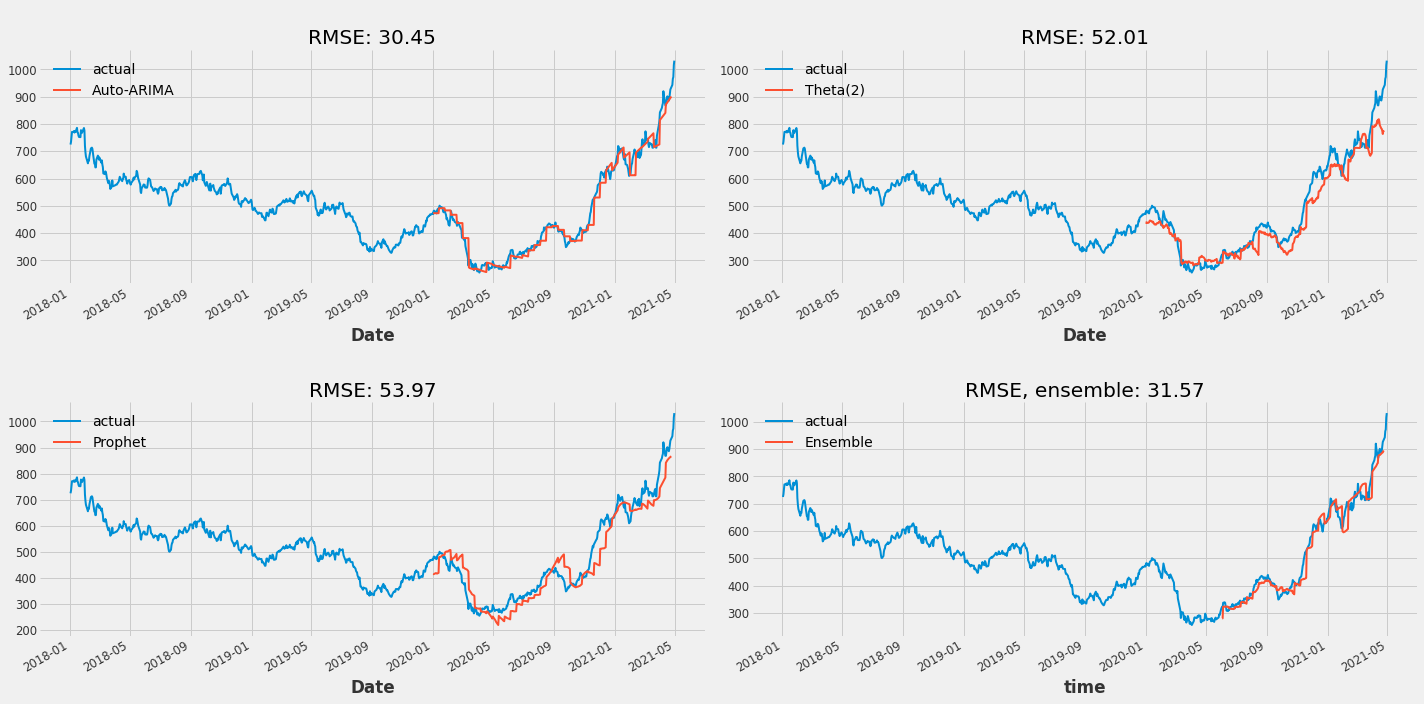

In [42]:
def muh_rmse(x, y):
    return np.round(np.sqrt(dme.mse(x, y)) ,2)

fig, ax = plt.subplots(2, 2, figsize=(CFG.img_dim1, CFG.img_dim2))
ax = ax.ravel()

for i, m in enumerate(models):
    series.plot(label='actual', ax=ax[i])
    model_predictions[i].plot(label=str(m), ax=ax[i])

    # intersect last part, to compare all the methods over the duration of the ensemble forecast
    model_pred = model_predictions[i].slice_intersect(ensemble_pred)

    # model_error = mape(series, model_pred)
    model_error = muh_rmse(series, model_pred)
    ax[i].set_title('\nRMSE: {:.2f}'.format(model_error))
    ax[i].legend()

series.plot(label='actual', ax=ax[3])
ensemble_pred.plot(label='Ensemble', ax=ax[3])
ax[3].set_title('\nRMSE, ensemble: {:.2f}'.format(muh_rmse(series, ensemble_pred)))
ax[3].legend()

print('\nRegression coefficients for the individual models:')
for i, m in enumerate(models):
    print('Learned coefficient for {}: {:.2f}'.format(m, regr_model.model.coef_[i]))
plt.tight_layout()

`Darts` takeaway:
* multiple models - statistics, DL, hybrid
* backstesting
* ensembling
* **transfer learning**